In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from qutip import *

### 1. Implement Gate Fidelity

##### This code is for verifying the gate fidelity of a gate. The goal is to use this to optimize fidelity to obtain the best gates possible.

In [17]:
def safe_fidelity(rho1, rho2, epsilon=1e-10):

    num = num_qubits(rho1)
    I = qeye(2)
    if num > 1:
        temp_I = qeye(2)
        while num > 1:
            I = tensor(I, temp_I)
            num -= 1

    rho1 = rho1 + epsilon * I
    rho2 = rho2 + epsilon * I
    return fidelity(rho1.unit(), rho2.unit())

def num_qubits(gate):

    if (gate.shape[0] > 2):
        dims = len(gate.dims)
    else:
        dims = 1
    return dims
    

def state_fidelity_after_gate(rho_in, ideal_gate, noisy_gate):
    rho_ideal = ideal_gate * rho_in * ideal_gate.dag()
    rho_noisy = noisy_gate * rho_in * noisy_gate.dag()
    return safe_fidelity(rho_noisy, rho_ideal)

def rho_TR(d):
    psi = sum(basis(d, i) for i in range(d)).unit()
    return ket2dm(psi)

def apply_unitary(U, rho):
    return U * rho * U.dag()

def F_TR(d, ideal_gate, noisy_gate):

    num = num_qubits(ideal_gate)
    rho_in = rho_TR(d)
    if num > 1:
        temp_rho_in = rho_TR(d)
        while num > 1:
            rho_in = tensor(rho_in, temp_rho_in)
            num -= 1
    
    rho_ideal = apply_unitary(ideal_gate, rho_in)
    rho_real = apply_unitary(noisy_gate, rho_in)
    return safe_fidelity(rho_real, rho_ideal)

def F_arith(d, ideal_gate, noisy_gate):
    F_basis_sum = 0.0
    for i in range(d):
        ket_i = basis(d, i)
        num = num_qubits(ideal_gate)
        if num > 1:
            ket_2 = basis(d, i)
            while num > 1:
                ket_i = tensor(ket_i, ket_2)
                num -= 1
        rho_i = ket2dm(ket_i)
        F_basis_sum += state_fidelity_after_gate(rho_i, ideal_gate, noisy_gate)
    return (F_basis_sum + F_TR(d, ideal_gate, noisy_gate)) / (d + 1)

def F_geom(d, ideal_gate, noisy_gate):
    F_basis_product = 1.0
    for i in range(d):
        ket_i = basis(d, i)
        num = num_qubits(ideal_gate)
        if num > 1:
            ket_2 = basis(d, i)
            while num > 1:
                ket_i = tensor(ket_i, ket_2)
                num -= 1
        rho_i = ket2dm(ket_i)
        F_basis_product *= state_fidelity_after_gate(rho_i, ideal_gate, noisy_gate)
    return (1 / (d + 1)) + ((1 - (1 / (d + 1))) * (F_TR(d, ideal_gate, noisy_gate) * F_basis_product))

def F_lambda(d, ideal_gate, noisy_gate):
    F_basis_product = 1.0
    for i in range(d):
        ket_i = basis(d, i)
        num = num_qubits(ideal_gate)
        if num > 1:
            ket_2 = basis(d, i)
            while num > 1:
                ket_i = tensor(ket_i, ket_2)
                num -= 1
        rho_i = ket2dm(ket_i)
        F_basis_product *= state_fidelity_after_gate(rho_i, ideal_gate, noisy_gate)
    lambda_factor = 1 - ((1 - F_basis_product) / (1 - (F_basis_product * F_TR(d, ideal_gate, noisy_gate))))
    return (lambda_factor * F_geom(d, ideal_gate, noisy_gate)) + ((1 - lambda_factor) * F_arith(d, ideal_gate, noisy_gate))

In [18]:
d = 2
U = rand_unitary(d)
print(F_lambda(d, U, U))

0.9999999998666664


### 2.A.2 Test gate fidelity

##### This code is for sanity checking that the code written to test gate fidelity above is functional

In [19]:
zero = basis(2,0)
one = basis(2,1)
plus = (zero + one) / np.sqrt(2)
minus = (zero - one) / np.sqrt(2)
complex = (zero + one *1j) / np.sqrt(2)

X = sigmax()

zero_out = X * zero
one_out = X * one
plus_out = X * plus
minus_out = X * minus
complex_out = X * complex

print('zero: ', zero.full(), '|', zero_out.full())
print('one: ', one.full(), '|', one_out.full())
print('plus: ', plus.full(), '|', plus_out.full())
print('minus: ', minus.full(), '|', minus_out.full())
print('complex', complex.full(), '|', complex_out.full())

zero:  [[1.+0.j]
 [0.+0.j]] | [[0.+0.j]
 [1.+0.j]]
one:  [[0.+0.j]
 [1.+0.j]] | [[1.+0.j]
 [0.+0.j]]
plus:  [[0.70710678+0.j]
 [0.70710678+0.j]] | [[0.70710678+0.j]
 [0.70710678+0.j]]
minus:  [[ 0.70710678+0.j]
 [-0.70710678+0.j]] | [[-0.70710678+0.j]
 [ 0.70710678+0.j]]
complex [[0.70710678+0.j        ]
 [0.        +0.70710678j]] | [[0.        +0.70710678j]
 [0.70710678+0.j        ]]


##### Here I am checking fidelity of the X gate against the X, Y, Z, and I gates as well as graphing the fidelity of the x gate against the rx rotation gate for values from 0 - 2 $\pi$

1.0000000000000004
0.33334666660071094
2.000013367615594e-05
0.3333466666333329


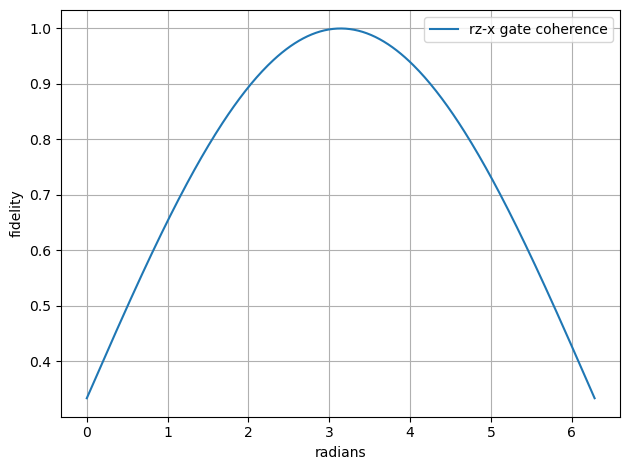

In [20]:

print(F_lambda(2, X, X))

print(F_lambda(2, X, sigmay()))
print(F_lambda(2, X, sigmaz()))
print(F_lambda(2, X, qeye(2)))

plt.figure()

pilist = np.linspace(0, 2 * np.pi, 360)
clist = []

for i in pilist:
    clist.append(F_lambda(2, X, gates.rx(i)))

plt.plot(pilist, clist, label='rz-x gate coherence')
plt.xlabel('radians')
plt.ylabel('fidelity')
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

##### Here I am checking how Qutip's built in average_gate_fidelity function compares to F_lambda, F_Geom, and F_Arith

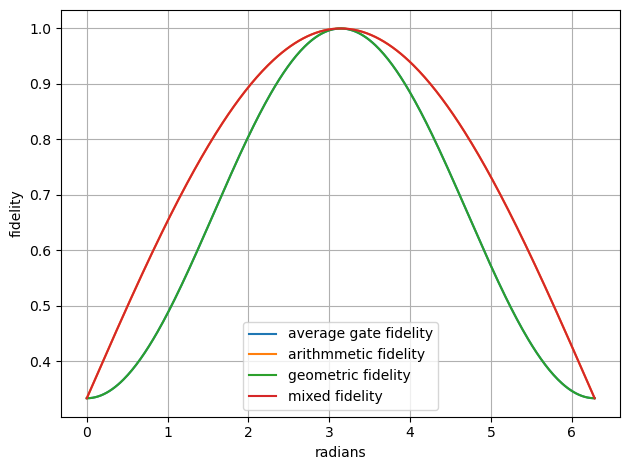

In [21]:
plt.figure()

pilist = np.linspace(0, 2 * np.pi, 360)
lambdas = np.linspace(0, 1, 100)
agflist = []
alist = []
glist = []
llist = []

for i in pilist:
    agflist.append(average_gate_fidelity(X, gates.rx(i)))

for i in pilist:
    alist.append(F_arith(2, X, gates.rx(i)))
    
for i in pilist:
    glist.append(F_geom(2, X, gates.rx(i)))

for i in pilist:
    llist.append(F_lambda(2, X, gates.rx(i)))


plt.plot(pilist, agflist, label='average gate fidelity')
plt.plot(pilist, alist, label='arithmmetic fidelity')
plt.plot(pilist, glist, label='geometric fidelity')
plt.plot(pilist, llist, label='mixed fidelity')
plt.xlabel('radians')
plt.ylabel('fidelity')
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

##### Now I am repeating all tests but with a random unitary gate instead of X

In [22]:
zero = basis(2,0)
one = basis(2,1)
plus = (zero + one) / np.sqrt(2)
minus = (zero - one) / np.sqrt(2)
complex = (zero + one *1j) / np.sqrt(2)

X = rand_unitary(2)

zero_out = X * zero
one_out = X * one
plus_out = X * plus
minus_out = X * minus
complex_out = X * complex

print('zero: ', zero.full(), '|', zero_out.full())
print('one: ', one.full(), '|', one_out.full())
print('plus: ', plus.full(), '|', plus_out.full())
print('minus: ', minus.full(), '|', minus_out.full())
print('complex', complex.full(), '|', complex_out.full())

zero:  [[1.+0.j]
 [0.+0.j]] | [[0.31336529+0.87482436j]
 [0.24849796-0.27337393j]]
one:  [[0.+0.j]
 [1.+0.j]] | [[-0.36432889+0.06122907j]
 [-0.56648327-0.73662213j]]
plus:  [[0.70710678+0.j]
 [0.70710678+0.j]] | [[-0.03603671+0.66188972j]
 [-0.22484957-0.71417506j]]
minus:  [[ 0.70710678+0.j]
 [-0.70710678+0.j]] | [[0.47920215+0.57529875j]
 [0.57627875+0.32756594j]]
complex [[0.70710678+0.j        ]
 [0.        +0.70710678j]] | [[0.17828723+0.36097481j]
 [0.69658509-0.59386872j]]


1.0000000011084296
0.5732477105588455
0.9419956393246428
0.48084681685724295


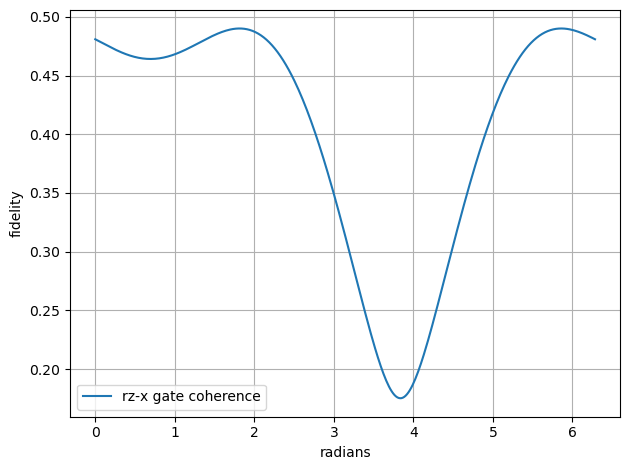

In [23]:

print(F_lambda(2, X, X))

print(F_lambda(2, X, sigmay()))
print(F_lambda(2, X, sigmaz()))
print(F_lambda(2, X, qeye(2)))

plt.figure()

pilist = np.linspace(0, 2 * np.pi, 360)
clist = []

for i in pilist:
    clist.append(F_lambda(2, X, gates.rx(i)))

plt.plot(pilist, clist, label='rz-x gate coherence')
plt.xlabel('radians')
plt.ylabel('fidelity')
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

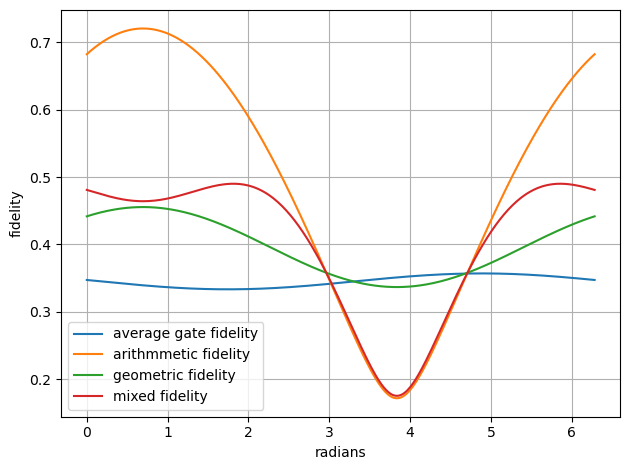

In [24]:
plt.figure()

pilist = np.linspace(0, 2 * np.pi, 360)
lambdas = np.linspace(0, 1, 100)
agflist = []
alist = []
glist = []
llist = []

for i in pilist:
    agflist.append(average_gate_fidelity(X, gates.rx(i)))

for i in pilist:
    alist.append(F_arith(2, X, gates.rx(i)))
    
for i in pilist:
    glist.append(F_geom(2, X, gates.rx(i)))

for i in pilist:
    llist.append(F_lambda(2, X, gates.rx(i)))


plt.plot(pilist, agflist, label='average gate fidelity')
plt.plot(pilist, alist, label='arithmmetic fidelity')
plt.plot(pilist, glist, label='geometric fidelity')
plt.plot(pilist, llist, label='mixed fidelity')
plt.xlabel('radians')
plt.ylabel('fidelity')
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### 2.A.3 Optimizing gate fidelity

##### Now we are optimizing gate fidelity. First step is to write a function which calculates the avearge gate fidelity between the ZXZ rotation gate and a random unitary for the three angles.

In [25]:
U = rand_unitary(2)

def ZXZ_rand_unitary_fidelity(thetas):
    
    return F_lambda(2, gates.rz(thetas[0]) * gates.rx(thetas[1]) * gates.rz(thetas[2]), U)

In [26]:
print(ZXZ_rand_unitary_fidelity(np.array([np.pi / 2, np.pi / 2, np.pi])))

0.6637614739779926


##### Using minimize to find a set of optimal angles. Using a callback function, saving the fidelity for each iteration. Plotting the fidelity versus iteration number. Trying with various solvers within minimize 

In [33]:
fidelitylist = []
iterations = [0]
iterationslist = []

def track_params(curr_params):
    iterations[0] += 1
    fidelitylist.append(ZXZ_rand_unitary_fidelity(curr_params))
    iterationslist.append(iterations[0])
    return curr_params

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.3762299486653706
        x: [ 2.884e+00  4.334e+00  3.760e+00]
      nit: 14
      jac: [-2.717e-01 -2.883e-01 -4.591e-02]
 hess_inv: [[ 3.701e-05  1.814e-04 -1.350e-03]
            [ 1.814e-04  8.900e-04 -6.621e-03]
            [-1.350e-03 -6.621e-03  4.926e-02]]
     nfev: 398
     njev: 97


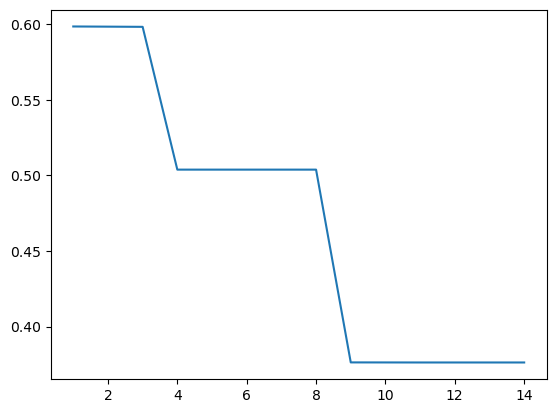

In [34]:
print(scipy.optimize.minimize(
    fun = ZXZ_rand_unitary_fidelity,
    x0 = [np.pi, np.pi, np.pi],
    callback = track_params,
    ))


plt.figure()

plt.plot(iterationslist, fidelitylist, label='ZXZ optimizing')

##### Now we are testing fidelity of XX against XX, XY, IZ, etc. AKA we are testing two qubit gates

XX : XX =  1.0000000110448017
XX : XY =  0.33334666808382113
XX : IZ =  2.0001075231249887e-05


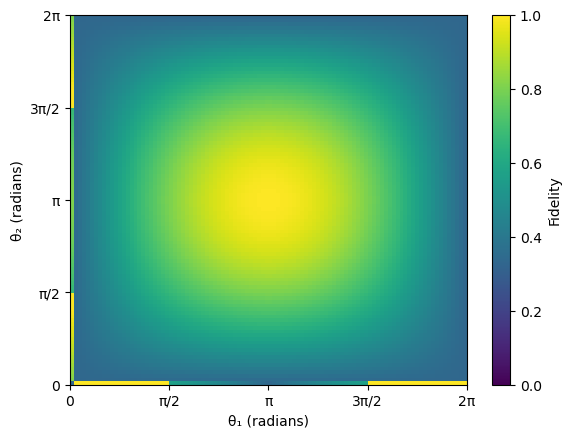

In [ ]:
XX = tensor(sigmax(), sigmax())
XY = tensor(sigmax(), sigmay())
IZ = tensor(qeye(2), sigmaz())

print('XX : XX = ', F_lambda(2, XX, XX))
print('XX : XY = ', F_lambda(2, XX, XY))
print('XX : IZ = ', F_lambda(2, XX, IZ))

theta_vals = np.linspace(0, 2*np.pi, 100)
T1, T2 = np.meshgrid(theta_vals, theta_vals)


F = np.empty_like(T1)
for i in range(T1.shape[0]):
    for j in range(T1.shape[1]):
        gate = tensor(gates.rx(T1[i,j]), gates.rx(T2[i,j]))
        F[i,j] = F_lambda(2, XX, gate)


plt.imshow(
    F, origin="lower",
    extent=[theta_vals.min(), theta_vals.max(), theta_vals.min(), theta_vals.max()],
    aspect="auto", vmin=0, vmax=1
)
plt.colorbar(label="Fidelity")
plt.xlabel("θ₁ (radians)")
plt.ylabel("θ₂ (radians)")
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ["0","π/2","π","3π/2","2π"])
plt.yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ["0","π/2","π","3π/2","2π"])
plt.show()

##### Attempting the same two qubit tests but with a random unitary tensor rather than XX

XX : XX =  0.6175093635814451
XX : XY =  0.33334666808382113
XX : IZ =  2.0001075231249887e-05


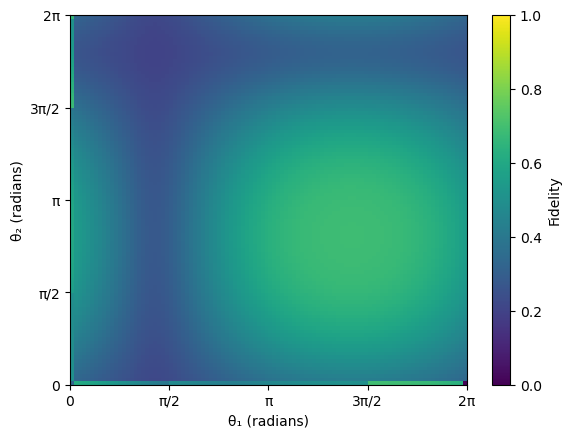

In [32]:
UU = tensor(rand_unitary(2), rand_unitary(2))
XX = tensor(sigmax(), sigmax())
XY = tensor(sigmax(), sigmay())
IZ = tensor(qeye(2), sigmaz())

print('XX : XX = ', F_lambda(2, UU, XX))
print('XX : XY = ', F_lambda(2, XX, XY))
print('XX : IZ = ', F_lambda(2, XX, IZ))

theta_vals = np.linspace(0, 2*np.pi, 100)
T1, T2 = np.meshgrid(theta_vals, theta_vals)


F = np.empty_like(T1)
for i in range(T1.shape[0]):
    for j in range(T1.shape[1]):
        gate = tensor(gates.rx(T1[i,j]), gates.rx(T2[i,j]))
        F[i,j] = F_lambda(2, UU, gate)


plt.imshow(
    F, origin="lower",
    extent=[theta_vals.min(), theta_vals.max(), theta_vals.min(), theta_vals.max()],
    aspect="auto", vmin=0, vmax=1
)
plt.colorbar(label="Fidelity")
plt.xlabel("θ₁ (radians)")
plt.ylabel("θ₂ (radians)")
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ["0","π/2","π","3π/2","2π"])
plt.yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ["0","π/2","π","3π/2","2π"])
plt.show()

##### Opimizing with a rz_rx_rz on each qubit

In [46]:
UU = tensor(rand_unitary(2), rand_unitary(2))
iterations[0] = 1
fidelitylist = []
iterationslist = []

def ZXZ_rand_unitary_fidelity2(thetas):
    return F_lambda(2, tensor(gates.rz(thetas[0]) * gates.rx(thetas[1]) * gates.rz(thetas[2]), gates.rz(thetas[3]) * gates.rx(thetas[4]) * gates.rz(thetas[5])), UU)

def track_params2(params):
    iterations[0] += 1
    fidelitylist.append(ZXZ_rand_unitary_fidelity2(params))
    iterationslist.append(iterations[0])
    return params

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 2.2080650420814276e-05
        x: [ 3.847e+00  3.339e+00  3.344e+00  3.526e+00  1.725e+00
             2.371e+00]
      nit: 33
      jac: [ 6.678e-03  2.056e-02  1.047e-02 -3.314e-04 -3.703e-03
             1.785e-02]
 hess_inv: [[ 1.712e-04  1.419e-04 ...  9.082e-05 -1.050e-04]
            [ 1.419e-04  5.204e-04 ...  5.542e-04 -3.862e-04]
            ...
            [ 9.082e-05  5.542e-04 ...  8.193e-04 -3.342e-04]
            [-1.050e-04 -3.862e-04 ... -3.342e-04  3.180e-04]]
     nfev: 740
     njev: 104


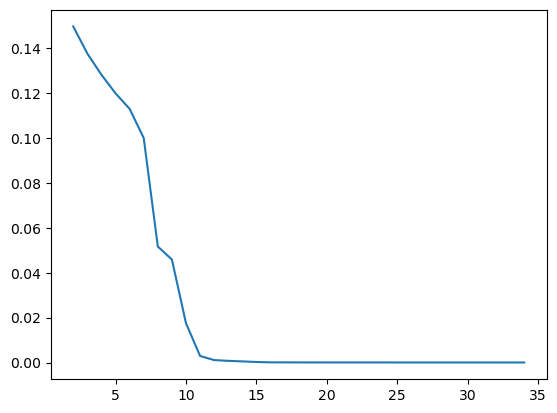

In [47]:
print(scipy.optimize.minimize(
    fun = ZXZ_rand_unitary_fidelity2,
    x0 = [np.pi, np.pi, np.pi, np.pi, np.pi, np.pi],
    callback = track_params2,
    ))

plt.figure()

plt.plot(iterationslist, fidelitylist, label='ZXZ 2 qubit optimizing')